In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrix
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42


config = Config()
sys.path.append(str(config.REPO_ROOT))
np.random.seed(config.seed)

### 5.3 GLM, GAM and more

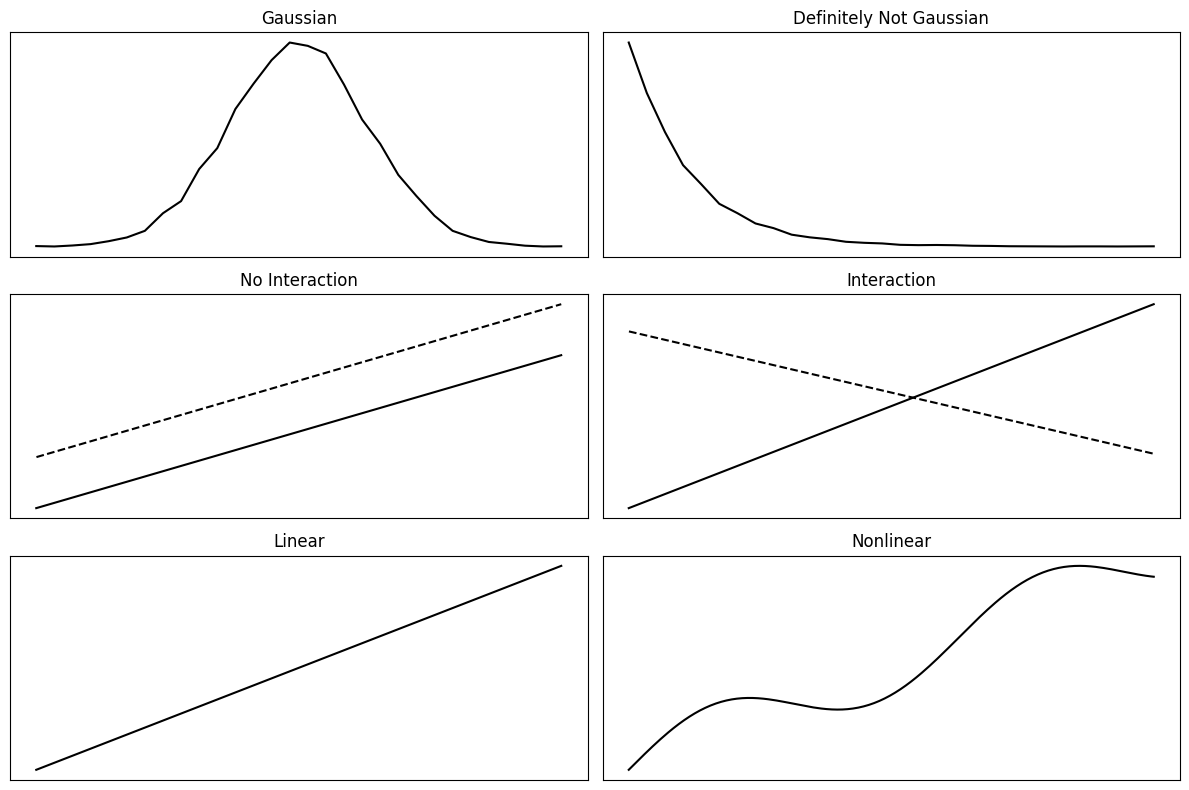

In [2]:
n = 10000
df_glm = pd.DataFrame(
    {
        "x": np.concatenate(
            [np.random.normal(size=n), np.random.exponential(scale=2, size=n)]
        ),
        "dist": ["Gaussian"] * n + ["Definitely Not Gaussian"] * n,
    }
)

x1 = np.linspace(-3, 3, n)
x2 = np.random.choice([1, 2], size=n, replace=True)
df = pd.DataFrame({"x1": x1, "x2": x2})
df["y"] = 3 + 5 * df["x1"] + (2 - 8 * df["x1"]) * (df["x2"] == 2)
df["interaction"] = "Interaction"
df2 = df.copy()
df2["y"] = 3 + 5 * df2["x1"] + 0.5 * (-8 * df2["x1"]) + 2 * (df2["x2"] == 2)
df2["interaction"] = "No Interaction"
df_interaction = pd.concat([df, df2], ignore_index=True)
df_interaction["interaction"] = pd.Categorical(
    df_interaction["interaction"],
    categories=["No Interaction", "Interaction"],
    ordered=True,
)

x = np.linspace(0, 10, 200)
y_linear = 5 + 2 * x
y_nonlinear = 3 + 2 * x + 3 * np.sin(x)
df_gam = pd.DataFrame(
    {
        "x": np.tile(x, 2),
        "y": np.concatenate([y_linear, y_nonlinear]),
        "type": ["Linear"] * len(x) + ["Nonlinear"] * len(x),
    }
)

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for dist, ax in zip(["Gaussian", "Definitely Not Gaussian"], axes[0]):
    df_subset = df_glm[df_glm["dist"] == dist]
    density, bins = np.histogram(df_subset["x"], bins=30, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    ax.plot(bin_centers, density, label=dist, color="black")
    ax.set_title(dist)
    ax.grid(False)

for interaction, ax in zip(["No Interaction", "Interaction"], axes[1]):
    df_subset = df_interaction.query("interaction ==@interaction")
    for x2_val, linestyle in zip([1, 2], ["solid", "dashed"]):
        subset = df_subset.query("x2 == @x2_val")
        ax.plot(
            subset["x1"],
            subset["y"],
            label=f"x2 = {x2_val}",
            linestyle=linestyle,
            color="black",
        )
    ax.set_title(interaction)
    ax.grid(False)

for gtype, ax in zip(["Linear", "Nonlinear"], axes[2]):
    df_subset = df_gam[df_gam["type"] == gtype]
    ax.plot(df_subset["x"], df_subset["y"], label=gtype, color="black")
    ax.set_title(gtype)
    ax.grid(False)

for ax in axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


### 5.3.1 Non-Gaussian Outcomes - GLMs

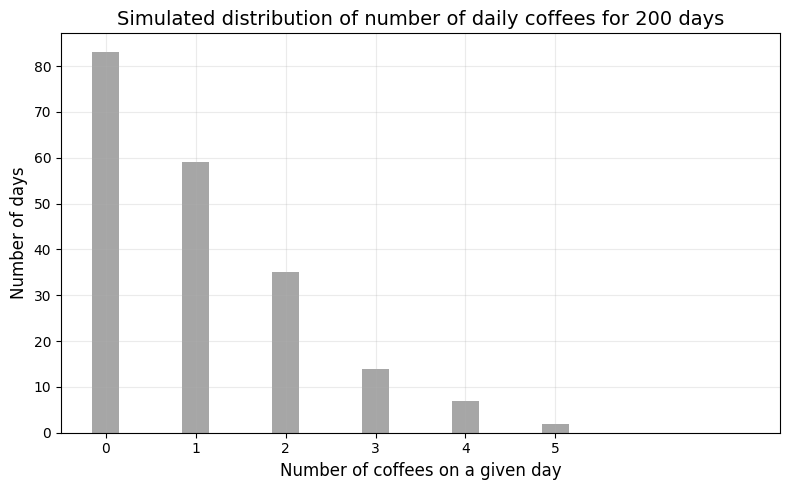

In [3]:
n = 200
stress = np.random.uniform(1, 10, size=n)
sleep = np.random.uniform(1, 10, size=n)
work = np.random.choice(["YES", "NO"], size=n, replace=True)
lambda_vals = np.exp(1 * stress / 10 - 2 * (sleep - 5) / 10 - 1 * (work == "NO"))
y = np.random.poisson(lam=lambda_vals, size=n)
df = pd.DataFrame({"stress": stress, "sleep": sleep, "work": work, "y": y})

tab = df["y"].value_counts().reset_index()
tab.columns = ["Number of Coffees", "Frequency"]
tab = tab.sort_values("Number of Coffees")

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(tab["Number of Coffees"], tab["Frequency"], color="gray", width=0.3, alpha=0.7)
ax.set_xlabel("Number of coffees on a given day", fontsize=12)
ax.set_ylabel("Number of days", fontsize=12)
ax.set_title(
    "Simulated distribution of number of daily coffees for 200 days", fontsize=14
)
ax.set_xticks(tab["Number of Coffees"])
ax.set_xlim([-0.5, 7.5])
ax.grid(linestyle="-", alpha=0.25)
plt.tight_layout()
plt.show()


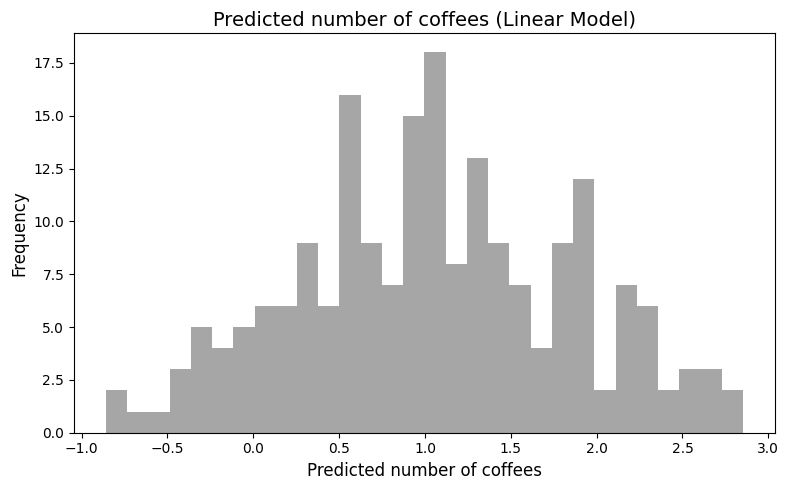

In [4]:
n = 200
stress = np.random.uniform(1, 10, size=n)
sleep = np.random.uniform(1, 10, size=n)
work = np.random.choice([1, 0], size=n)
lambda_vals = np.exp(1 * stress / 10 - 2 * (sleep - 5) / 10 - work)
y = np.random.poisson(lam=lambda_vals, size=n)
df = pd.DataFrame({"stress": stress, "sleep": sleep, "work": work, "y": y})
X = df[["stress", "sleep", "work"]]
y = df["y"]

model_gauss = LinearRegression()
model_gauss.fit(X, y)
pred_gauss = model_gauss.predict(X)


fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(pred_gauss, bins=30, color="gray", edgecolor=None, alpha=0.7)
ax.set_xlabel("Predicted number of coffees", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Predicted number of coffees (Linear Model)", fontsize=14)
plt.tight_layout()
plt.show()


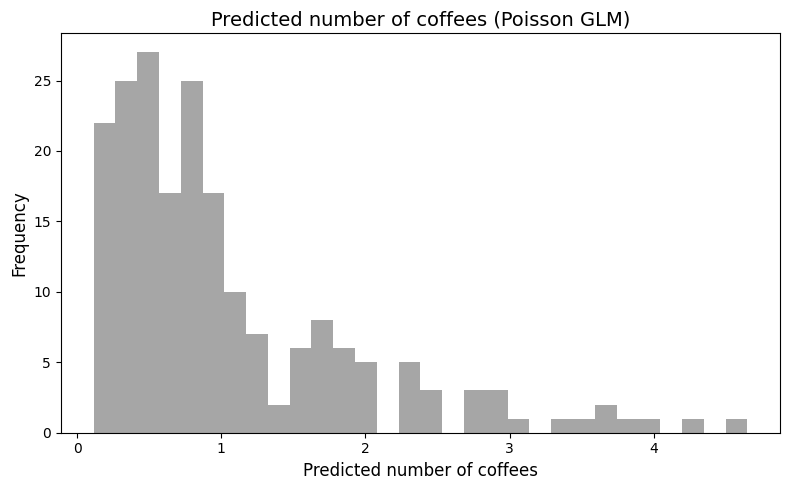

In [5]:
X = df[["stress", "sleep", "work"]]
X = sm.add_constant(X)
y = df["y"]

model_pois = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
results_pois = model_pois.fit()

pred_pois = results_pois.predict(X)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(pred_pois, bins=30, color="gray", edgecolor=None, alpha=0.7)
ax.set_xlabel("Predicted number of coffees", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Predicted number of coffees (Poisson GLM)", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
X = df[["stress", "sleep", "work"]]
X = sm.add_constant(X)
y = df["y"]

model_pois = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
results_pois = model_pois.fit()

coefficients = results_pois.summary2().tables[1]
coefficients = coefficients[
    [
        "Coef.",
        "[0.025",
        "0.975]",
    ]
]
coefficients.columns = ["weight", "[2.5%", "97.5%]"]

coefficients["exp(weight)"] = np.exp(coefficients["weight"])
coefficients = coefficients[["weight", "exp(weight)", "[2.5%", "97.5%]"]]
display(coefficients)

,weight,exp(weight),[2.5%,97.5%]
const,0.998184,2.713349,0.520644,1.475723
stress,0.101281,1.106588,0.046676,0.155887
sleep,-0.231988,0.792956,-0.292450,-0.171526
work,-1.048598,0.350429,-1.361268,-0.735927


#### Example

In [7]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [8]:
bike_features_of_interest = [
    "season",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "hum",
    "windspeed",
    "days_since_2011",
]

X = df_bike_processed[bike_features_of_interest]
y = df_bike_processed["cnt"]
dat = pd.concat([X, y], axis=1)

model_formula = f"cnt ~ C(season) + C(holiday) + C(workingday) + C(weathersit) + temp + hum + windspeed + days_since_2011 + temp:C(workingday)"
mod = ols(model_formula, data=dat).fit()

lm_summary = mod.summary2().tables[1]
lm_summary["t value"] = np.abs(lm_summary["t"])
lm_summary = lm_summary.rename(
    index={
        "Intercept": "Intercept",
        "C(season)[T.SUMMER]": "season[T.SUMMER]",
        "C(season)[T.FALL]": "season[T.FALL]",
        "C(season)[T.WINTER]": "season[T.WINTER]",
        "C(holiday)[T.HOLIDAY]": "holiday[T.HOLIDAY]",
        "C(workingday)[T.WORKING DAY]": "workingday[T.WORKING DAY]",
        "C(weathersit)[T.MISTY]": "weathersit[T.MISTY]",
        "C(weathersit)[T.RAIN/SNOW/STORM]": "weathersit[T.RAIN/SNOW/STORM]",
        "temp:C(workingday)[T.WORKING DAY]": "temp:workingday[T.WORKING DAY]",
    }
)


lm_summary_print = lm_summary[["Coef.", "Std.Err.", "t value"]].rename(
    columns={"Coef.": "Weight", "Std.Err.": "SE", "t value": "|t|"}
)
lm_summary_print = lm_summary_print.round(1)

display(lm_summary_print)

,Weight,SE,|t|
Intercept,2185.8,250.2,8.7
C(season)[T.SPRING],893.8,121.8,7.3
season[T.SUMMER],137.1,161.0,0.9
season[T.FALL],426.5,110.3,3.9
holiday[T.HOLIDAY],-674.4,202.5,3.3
workingday[T.WORKING DAY],451.9,141.7,3.2
weathersit[T.MISTY],-382.1,87.2,4.4
weathersit[T.RAIN/SNOW/STORM],-1898.2,222.7,8.5
temp,125.4,8.9,14.1
temp:workingday[T.WORKING DAY],-21.8,8.1,2.7


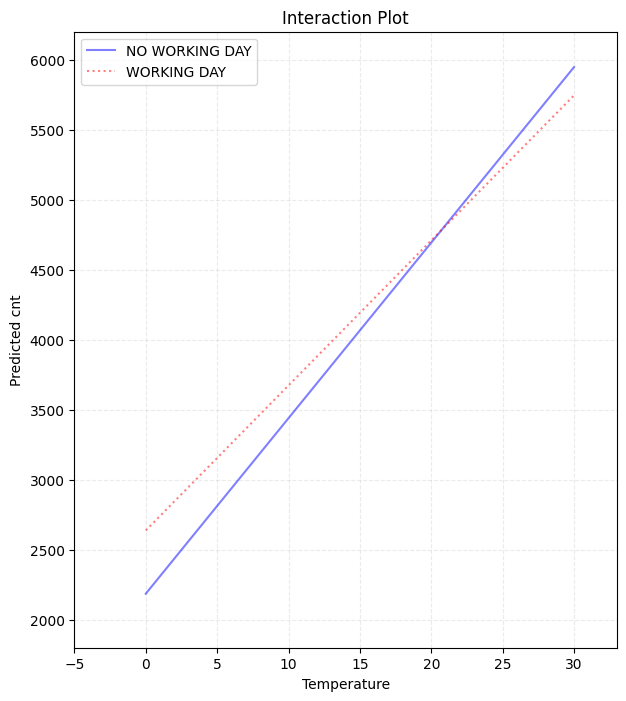

In [9]:
temp_slope_no_workingday = lm_summary_print.loc["temp", "Weight"]
temp_slope_workingday = (
    lm_summary_print.loc["temp", "Weight"]
    + lm_summary_print.loc["temp:workingday[T.WORKING DAY]", "Weight"]
)

intercept_no_workingday = lm_summary_print.loc["Intercept", "Weight"]
intercept_workingday = (
    lm_summary_print.loc["Intercept", "Weight"]
    + lm_summary_print.loc["workingday[T.WORKING DAY]", "Weight"]
)

fig, ax = plt.subplots(figsize=(7, 8))
ax.plot(
    [0, 30],
    [intercept_no_workingday, intercept_no_workingday + temp_slope_no_workingday * 30],
    color="blue",
    label="NO WORKING DAY",
    alpha=0.5,
)
ax.plot(
    [0, 30],
    [intercept_workingday, intercept_workingday + temp_slope_workingday * 30],
    color="red",
    linestyle="dotted",
    label="WORKING DAY",
    alpha=0.5,
)
ax.set_xlim(-5, 33)
ax.set_ylim(1800, 6200)
ax.set_xlabel("Temperature")
ax.set_ylabel("Predicted cnt")
ax.set_title("Interaction Plot")
ax.grid(linestyle="--", alpha=0.25)
ax.legend()
plt.show()

### 5.3.3 Nonlinear Effects - GAMs

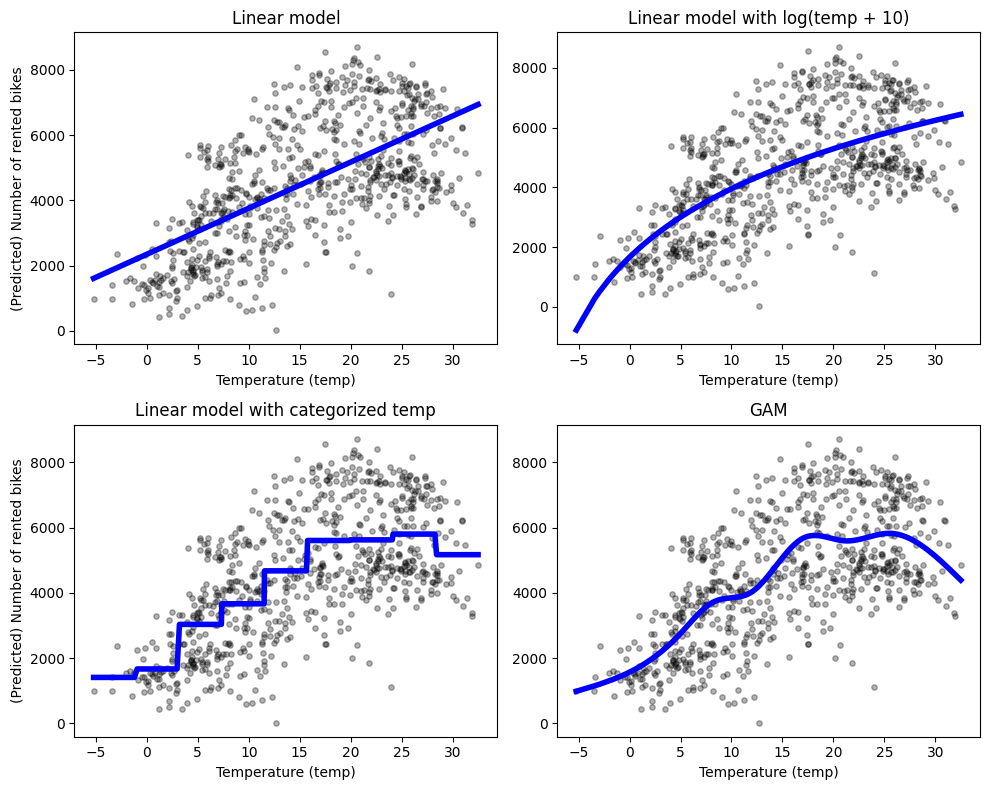

In [10]:
mod_simple = ols("cnt ~ temp", data=df_bike_processed).fit()
df_bike_processed["pred.lm"] = mod_simple.predict(df_bike_processed)
df_bike_processed["log.temp"] = np.log(df_bike_processed["temp"] + 10)
mod_log = ols("cnt ~ np.log(temp + 10)", data=df_bike_processed).fit()
df_bike_processed["pred.sqrt"] = mod_log.predict(df_bike_processed)
df_bike_processed["cat_temp"] = pd.cut(
    df_bike_processed["temp"],
    bins=np.linspace(
        df_bike_processed["temp"].min(), df_bike_processed["temp"].max(), 10
    ),
    include_lowest=True,
    labels=False,
)
mod_cat = ols("cnt ~ C(cat_temp)", data=df_bike_processed).fit()
df_bike_processed["pred.cat"] = mod_cat.predict(df_bike_processed)

transformed_x = dmatrix(
    "cr(temp, df=8)", {"temp": df_bike_processed["temp"]}, return_type="dataframe"
)
mod_gam = sm.GLM(df_bike_processed["cnt"], transformed_x).fit()
df_bike_processed["pred.gam"] = mod_gam.predict(transformed_x)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

model_types = {
    "pred.lm": "Linear model",
    "pred.sqrt": "Linear model with log(temp + 10)",
    "pred.cat": "Linear model with categorized temp",
    "pred.gam": "GAM",
}
df_bike_processed = df_bike_processed.sort_values("temp")
for i, (col, title) in enumerate(model_types.items()):
    ax = axes[i]
    ax.scatter(
        df_bike_processed["temp"],
        df_bike_processed["cnt"],
        s=15,
        alpha=0.3,
        color="black",
    )
    ax.plot(
        df_bike_processed["temp"], df_bike_processed[col], color="blue", linewidth=4
    )
    ax.set_title(title)
    ax.set_xlabel("Temperature (temp)")
    if i == 0 or i == 2:
        ax.set_ylabel("(Predicted) Number of rented bikes")

plt.tight_layout()
plt.show()

Splines DataFrame:


,Intercept,"cr(temp, df=4)[0]","cr(temp, df=4)[1]","cr(temp, df=4)[2]","cr(temp, df=4)[3]"
21,1.0,1.00,0.00,0.00,0.00
22,1.0,0.84,0.22,-0.07,0.01
23,1.0,0.84,0.22,-0.07,0.01
368,1.0,0.80,0.28,-0.09,0.01
407,1.0,0.72,0.39,-0.13,0.02


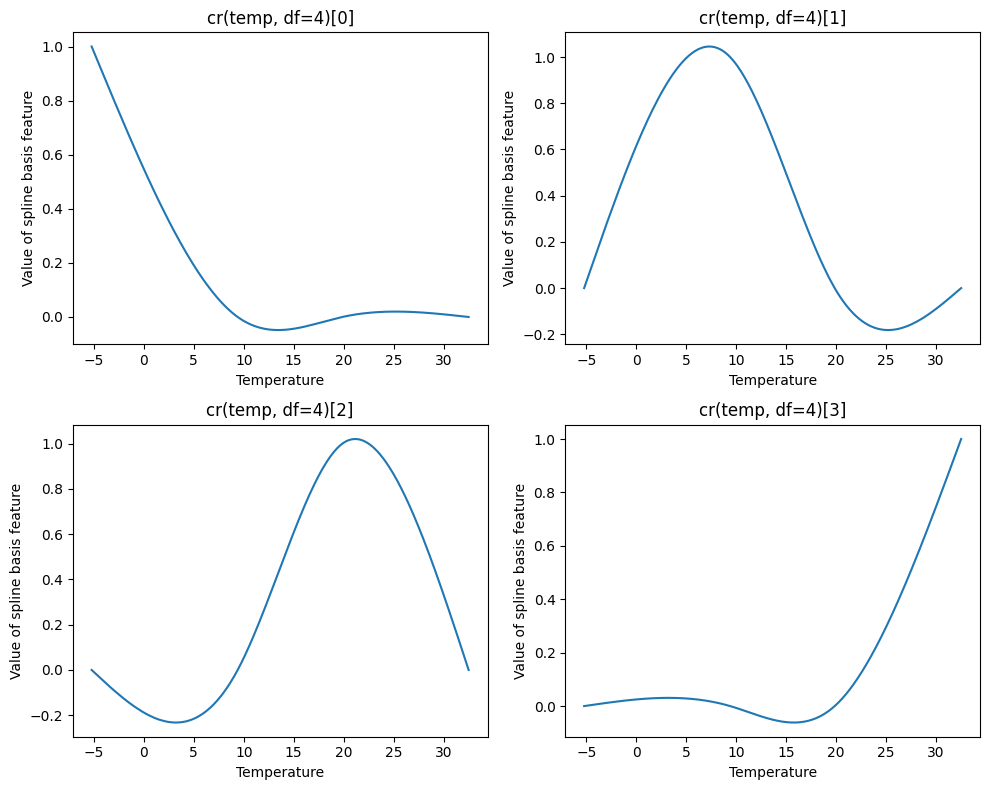

In [11]:
transformed_x = dmatrix(
    "cr(temp, df=4)", {"temp": df_bike_processed["temp"]}, return_type="dataframe"
)
mod_gam = sm.GLM(df_bike_processed["cnt"], transformed_x).fit()
model_matrix = pd.DataFrame(transformed_x)

print("Splines DataFrame:")
display(model_matrix.head().round(2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
spline_cols = [col for col in model_matrix.columns if col != "Intercept"]

for i, col in enumerate(spline_cols):
    ax = axes[i]
    ax.plot(df_bike_processed["temp"], model_matrix[col], label=col)
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Value of spline basis feature")
    ax.set_title(col)
plt.tight_layout()
plt.show()